In [123]:
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from time import sleep
from IPython.display import clear_output

In [254]:
class Grid():
    
    '''
    Generates and operates the grid structure that the snake game will be playing in.
    
    This will be in a matrix:
    [ 0 0 0 0 ]
    [ 0 0 0 0 ]
    [ 0 0 0 0 ]
    [ 0 0 0 0 ]
    
    Wherein the starting position (0,0) is the upper left corner and the maximum position
    is at (max_x, max_y) at the lower right of the square.
    
    All non-zero elements will be considered as occupied, therefore the board will be 
    initiated with:
    [ 1 1 1 1 ]
    [ 1 0 0 1 ]
    [ 1 0 0 1 ]
    [ 1 1 1 1 ]
    wherein the 1s denote the borders of the board.
    '''
    
    def __init__(self, max_x, max_y, snake):
        
        '''
        Generates an empty square board with size (max_x, max_y). This is generated using a
        numpy matrix of 0s wherein a border of 1s is added all around the play space.
        '''
        
        self.width = max_x
        self.height = max_y
        self.board = np.zeros((self.width+2, self.height+2))
        self.board[0] = 1
        self.board[-1] = 1
        self.board[:,0] = 1
        self.board[:,-1] = 1
        for i in snake.body:
            self.board[i[0],i[1]] = 1
        self.board[snake.head_coord[0], snake.head_coord[1]] = 1
        
    def reset(self):
        
        '''
        Erases the board and restarts it to the beginning state.
        '''
        
        self.board = np.zeros((self.width+2, self.height+2))
        
    def food(self):
        food_idx = np.random.choice(np.argsort(self.board.flatten())\
                                      [:(self.board < 1).sum()])
        row = food_idx // self.board.shape[0]
        col = food_idx - (self.board.shape[0] * row)
        self.board[row,col] = 2

In [256]:
class Snake():
    '''
    Generates a new Snake agent that can be used to play the snake game.
    
    For the snake actions:
    
    UP = 1
    DOWN = 2
    LEFT = 3
    RIGHT = 4
    
    '''
    
    UP = 1
    DOWN = 2
    LEFT = 3
    RIGHT = 4

    
    def __init__(self, starting_head_coord, length=3):
        self.direction = 1
        self.head_coord = np.asarray(starting_head_coord)
        self.body = deque()
        for i in range(length-1, 0, -1):
            self.body.append((self.head_coord - np.array([0,i])).astype(int))
        self.length = length
        
    def step(self, action):

        self.body.append(self.head_coord)

        if action == 1:
            self.head_coord = self.head_coord + np.array([-1,0])
        elif action == 2:
            self.head_coord = self.head_coord + np.array([1,0])
        elif action == 3:
            self.head_coord = self.head_coord + np.array([0,-1])
        elif action == 4:
            self.head_coord = self.head_coord + np.array([0,1])


In [ ]:
class SnakeGame():
    
    '''
    Defines the wrapper function that manipulates the Snake and Grid classes to play a 
    game of snake. This will be used for the gym_env wrapper.
    '''

    def __init__(self, width, height):
        self.snake = Snake()
        self.grid = Grid(width, height)
        

In [212]:
snek = Snake(np.array([20,20]))

In [213]:
snek.step(4)
snek.step(1)
snek.step(1)
snek.step(1)
snek.step(1)

In [214]:
snek.body

deque([array([20, 18]),
       array([20, 19]),
       array([20, 20]),
       array([20, 21]),
       array([19, 21]),
       array([18, 21]),
       array([17, 21])])

In [215]:
x = Grid(40,40)

In [249]:
x.food(None)

In [250]:
grid = x.board.copy()

In [251]:
for i in snek.body:
    grid[i[0], i[1]] = 1
    print(i)
grid[snek.head_coord[0], snek.head_coord[1]] = 1

[20 18]
[20 19]
[20 20]
[20 21]
[19 21]
[18 21]
[17 21]
[16 21]
[16 20]
[16 19]
[16 18]
[16 17]
[16 16]
[17 16]
[18 16]
[19 16]
[19 15]


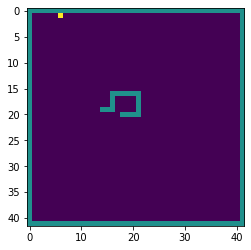

In [252]:
plt.imshow(grid)

In [246]:
snek.step(3)

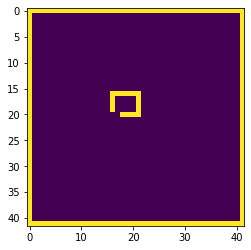

In [241]:
plt.imshow(grid)

In [224]:
snek.head_coord + np.array([0, -1])

array([16, 19])